In [12]:
from envs.custom_env import ProbabilityThresholdEnv
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque, namedtuple
import gymnasium as gym
import matplotlib.pyplot as plt
from tqdm import tqdm

In [47]:
# 定義 Experience 命名元組來存儲經驗樣本
Experience = namedtuple(
    "Experience", ("state", "action", "next_state", "reward", "done")
)


# 定義經驗回放緩衝區
class ReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, next_state, reward, done):
        """保存一個轉換"""
        self.memory.append(Experience(state, action, next_state, reward, done))

    def sample(self, batch_size):
        """隨機抽取一批經驗"""
        experiences = random.sample(self.memory, batch_size)

        # 將樣本轉換為張量批次
        states = torch.FloatTensor(np.array([exp.state for exp in experiences]))
        actions = torch.LongTensor(
            np.array([exp.action for exp in experiences]).reshape(-1, 1)
        )
        next_states = torch.FloatTensor(
            np.array([exp.next_state for exp in experiences])
        )
        rewards = torch.FloatTensor(
            np.array([exp.reward for exp in experiences]).reshape(-1, 1)
        )
        dones = torch.FloatTensor(
            np.array([exp.done for exp in experiences]).reshape(-1, 1)
        )

        return states, actions, next_states, rewards, dones

    def __len__(self):
        return len(self.memory)

    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size


# 定義 DQN 網絡
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


# 定義 DQN Agent
class DQNAgent:
    def __init__(self, state_dim, action_dim, device="cpu"):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.device = device

        # Q 網絡
        self.policy_net = DQN(state_dim, action_dim).to(device)
        self.target_net = DQN(state_dim, action_dim).to(device)
        self.update_target_network()
        self.target_net.eval()  # 設置為評估模式

        # 超參數
        self.gamma = 0.99  # 折扣因子
        self.epsilon_start = 1.0
        self.epsilon_end = 0.05
        self.epsilon_decay = 10000
        self.epsilon = self.epsilon_start
        self.steps_done = 0

        # 優化器
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=1e-4)

        # 回放緩衝區
        self.memory = ReplayBuffer(10000)
        self.batch_size = 64

        # 訓練設置
        self.target_update = 1000  # 目標網絡更新頻率

    def update_target_network(self):
        """將策略網絡的權重複製到目標網絡"""
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def get_action(self, state, eval_mode=False):
        """使用epsilon-greedy策略選擇動作"""
        # 逐步減小 epsilon 值
        self.epsilon = self.epsilon_end + (
            self.epsilon_start - self.epsilon_end
        ) * np.exp(-1.0 * self.steps_done / self.epsilon_decay)
        self.steps_done += 1

        if eval_mode:
            # 在評估模式下，我們總是選擇最佳動作
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.policy_net(state_tensor)
                return q_values.argmax().item()

        # Epsilon-greedy 動作選擇
        if random.random() > self.epsilon:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.policy_net(state_tensor)
                return q_values.argmax().item()
        else:
            return random.randrange(self.action_dim)

    def learn(self):
        """從回放緩衝區更新策略網絡"""
        if not self.memory.can_provide_sample(self.batch_size):
            return

        # 採樣一批經驗
        states, actions, next_states, rewards, dones = self.memory.sample(
            self.batch_size
        )
        states = states.to(self.device)
        actions = actions.to(self.device)
        next_states = next_states.to(self.device)
        rewards = rewards.to(self.device)
        dones = dones.to(self.device)

        # 計算當前 Q 值：Q(s, a)
        current_q_values = self.policy_net(states).gather(1, actions)

        # 計算目標 Q 值：r + γ * max_a' Q_target(s', a')
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1, keepdim=True)[0]
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # 計算 Huber 損失
        loss = F.smooth_l1_loss(current_q_values, target_q_values)

        # 優化模型
        self.optimizer.zero_grad()
        loss.backward()
        # 梯度裁剪，以防止爆炸梯度
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 10)
        self.optimizer.step()

        return loss.item()

    def save(self, path):
        """保存模型"""
        torch.save(
            {
                "policy_net": self.policy_net.state_dict(),
                "target_net": self.target_net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            },
            path,
        )

    def load(self, path):
        """載入模型"""
        checkpoint = torch.load(path)
        self.policy_net.load_state_dict(checkpoint["policy_net"])
        self.target_net.load_state_dict(checkpoint["target_net"])
        self.optimizer.load_state_dict(checkpoint["optimizer"])


# 訓練與評估函數
def train_dqn(env, agent, num_episodes=1000, max_steps=500, learn_interval=10):
    """訓練 DQN 代理"""
    rewards = []

    for episode in tqdm(range(num_episodes)):
        state, _ = env.reset()
        episode_reward = 0

        for step in range(max_steps):
            # 選擇動作
            action = agent.get_action(state)

            # 執行動作
            next_state, reward, done, truncated, _ = env.step(action)

            # 保存經驗
            agent.memory.push(state, action, next_state, reward, done)

            # 更新狀態和累積獎勵
            state = next_state
            episode_reward += reward

            # 更新模型
            if step % learn_interval == 0:
                loss = agent.learn()
                

            # 更新目標網絡
            if agent.steps_done % agent.target_update == 0:
                agent.update_target_network()

            if done or truncated:
                print(f"Episode {episode} finished after {step + 1} steps")
                break

        rewards.append(episode_reward)

        # 打印進度
        if episode % 10 == 0:
            avg_reward = np.mean(rewards[-10:])
            print(
                f"Episode {episode}, Avg Reward: {avg_reward:.2f}, Epsilon: {agent.epsilon:.2f}"
            )

    return rewards


def evaluate_agent(env, agent, num_episodes=10):
    """評估 DQN 代理"""
    total_rewards = []

    for _ in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False

        while not done:
            action = agent.get_action(state, eval_mode=True)
            next_state, reward, done, truncated, _ = env.step(action)
            state = next_state
            episode_reward += reward
            done = done or truncated

        total_rewards.append(episode_reward)

    avg_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)
    print(f"Evaluation: Avg Reward: {avg_reward:.2f} +/- {std_reward:.2f}")

    return avg_reward, std_reward


# 創建環境和代理
def main():
    # 創建環境
    train_env = ProbabilityThresholdEnv(
        csv_path="./data/rl_train.csv",
        rf_bounds=(0.89, 0.93),
        xgb_bounds=(0.96, 1),
        svm_bounds=(0.88, 0.92),
        step_size=0.01,
        isTrain=True,
        num_clf=1,
        max_n_steps=10000,
        random_seed=42,
    )

    # 創建測試環境
    test_env = ProbabilityThresholdEnv(
        csv_path="./data/rl_test.csv",
        rf_bounds=(0.89, 0.93),
        xgb_bounds=(0.96, 1),
        svm_bounds=(0.88, 0.92),
        step_size=0.01,
        isTrain=False,
        num_clf=1,
        max_n_steps=10000,
        random_seed=42,
    )

    # 獲取環境的維度
    state_dim = train_env.observation_space.shape[0]
    action_dim = train_env.action_space.n

    # 創建 DQN 代理
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    agent = DQNAgent(state_dim, action_dim, device)

    # 訓練代理
    rewards = train_dqn(train_env, agent, num_episodes=300, max_steps=1000)

    # 保存經過訓練的代理
    agent.save("dqn_model.pth")

    # 評估代理
    avg_reward, std_reward = evaluate_agent(test_env, agent)

    # 繪製學習曲線
    plt.figure(figsize=(10, 5))
    plt.plot(rewards)
    plt.title("DQN Learning Curve")
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward")
    plt.savefig("learning_curve.png")
    plt.show()




Balanced training dataset with 10000 samples
Loaded testing dataset with 275 samples
Using device: cpu


  1%|          | 2/300 [00:00<00:26, 11.28it/s]

Episode 0, Avg Reward: 218.00, Epsilon: 0.91


  4%|▍         | 12/300 [00:01<00:29,  9.91it/s]

Episode 10, Avg Reward: 286.20, Epsilon: 0.37


  7%|▋         | 22/300 [00:02<00:30,  9.08it/s]

Episode 20, Avg Reward: 332.40, Epsilon: 0.17


 11%|█         | 32/300 [00:03<00:31,  8.63it/s]

Episode 30, Avg Reward: 353.20, Epsilon: 0.09


 14%|█▍        | 42/300 [00:04<00:29,  8.77it/s]

Episode 40, Avg Reward: 351.80, Epsilon: 0.07


 17%|█▋        | 52/300 [00:05<00:28,  8.81it/s]

Episode 50, Avg Reward: 352.40, Epsilon: 0.06


 21%|██        | 62/300 [00:06<00:30,  7.85it/s]

Episode 60, Avg Reward: 364.20, Epsilon: 0.05


 24%|██▍       | 72/300 [00:08<00:26,  8.52it/s]

Episode 70, Avg Reward: 346.20, Epsilon: 0.05


 27%|██▋       | 82/300 [00:09<00:24,  8.87it/s]

Episode 80, Avg Reward: 338.40, Epsilon: 0.05


 31%|███       | 92/300 [00:10<00:23,  8.94it/s]

Episode 90, Avg Reward: 354.60, Epsilon: 0.05


 34%|███▍      | 102/300 [00:11<00:21,  9.03it/s]

Episode 100, Avg Reward: 349.20, Epsilon: 0.05


 37%|███▋      | 112/300 [00:12<00:21,  8.69it/s]

Episode 110, Avg Reward: 360.60, Epsilon: 0.05


 41%|████      | 122/300 [00:13<00:20,  8.83it/s]

Episode 120, Avg Reward: 353.00, Epsilon: 0.05


 44%|████▍     | 132/300 [00:14<00:19,  8.74it/s]

Episode 130, Avg Reward: 329.60, Epsilon: 0.05


 47%|████▋     | 142/300 [00:16<00:18,  8.76it/s]

Episode 140, Avg Reward: 346.40, Epsilon: 0.05


 51%|█████     | 152/300 [00:17<00:16,  8.88it/s]

Episode 150, Avg Reward: 340.80, Epsilon: 0.05


 54%|█████▍    | 162/300 [00:18<00:15,  8.71it/s]

Episode 160, Avg Reward: 352.40, Epsilon: 0.05


 57%|█████▋    | 172/300 [00:19<00:14,  8.86it/s]

Episode 170, Avg Reward: 340.40, Epsilon: 0.05


 61%|██████    | 182/300 [00:20<00:13,  8.53it/s]

Episode 180, Avg Reward: 349.80, Epsilon: 0.05


 64%|██████▍   | 192/300 [00:21<00:12,  8.83it/s]

Episode 190, Avg Reward: 339.40, Epsilon: 0.05


 67%|██████▋   | 202/300 [00:23<00:11,  8.71it/s]

Episode 200, Avg Reward: 353.40, Epsilon: 0.05


 71%|███████   | 212/300 [00:24<00:09,  8.91it/s]

Episode 210, Avg Reward: 357.20, Epsilon: 0.05


 74%|███████▍  | 222/300 [00:25<00:08,  8.87it/s]

Episode 220, Avg Reward: 339.40, Epsilon: 0.05


 77%|███████▋  | 232/300 [00:26<00:08,  8.04it/s]

Episode 230, Avg Reward: 354.40, Epsilon: 0.05


 81%|████████  | 242/300 [00:27<00:06,  8.74it/s]

Episode 240, Avg Reward: 344.00, Epsilon: 0.05


 84%|████████▍ | 252/300 [00:28<00:05,  8.85it/s]

Episode 250, Avg Reward: 357.80, Epsilon: 0.05


 87%|████████▋ | 262/300 [00:29<00:04,  8.94it/s]

Episode 260, Avg Reward: 338.00, Epsilon: 0.05


 91%|█████████ | 272/300 [00:31<00:03,  8.86it/s]

Episode 270, Avg Reward: 358.40, Epsilon: 0.05


 94%|█████████▍| 282/300 [00:32<00:02,  8.79it/s]

Episode 280, Avg Reward: 338.20, Epsilon: 0.05


 97%|█████████▋| 292/300 [00:33<00:00,  8.77it/s]

Episode 290, Avg Reward: 353.20, Epsilon: 0.05


100%|██████████| 300/300 [00:34<00:00,  8.75it/s]


Evaluation: Avg Reward: 81.00 +/- 0.00


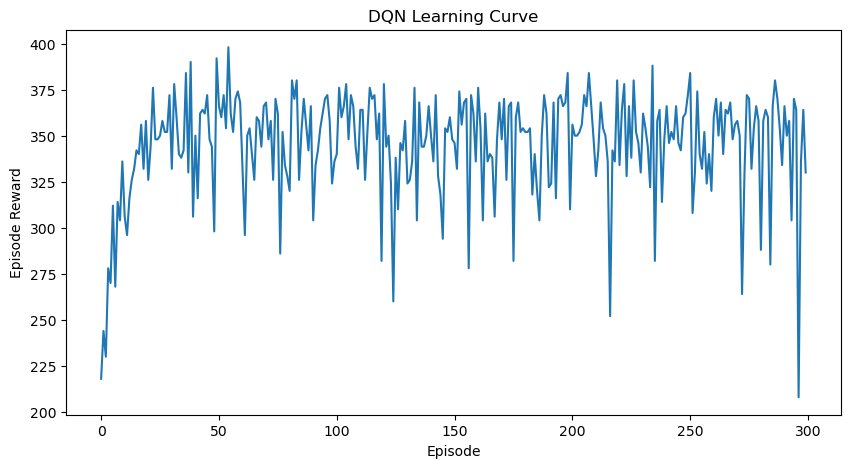

In [ ]:
main() # use training data for testing, clf=1

Balanced training dataset with 10000 samples
Loaded testing dataset with 275 samples
Using device: cpu


  1%|          | 2/300 [00:00<00:28, 10.60it/s]

Episode 0, Avg Reward: 562.00, Epsilon: 0.91


  4%|▍         | 12/300 [00:01<00:30,  9.50it/s]

Episode 10, Avg Reward: 644.40, Epsilon: 0.37


  7%|▋         | 22/300 [00:02<00:31,  8.81it/s]

Episode 20, Avg Reward: 683.40, Epsilon: 0.17


 11%|█         | 32/300 [00:03<00:30,  8.72it/s]

Episode 30, Avg Reward: 773.80, Epsilon: 0.09


 14%|█▍        | 42/300 [00:04<00:30,  8.52it/s]

Episode 40, Avg Reward: 774.40, Epsilon: 0.07


 17%|█▋        | 52/300 [00:05<00:30,  8.22it/s]

Episode 50, Avg Reward: 756.80, Epsilon: 0.06


 21%|██        | 62/300 [00:07<00:28,  8.43it/s]

Episode 60, Avg Reward: 755.80, Epsilon: 0.05


 24%|██▍       | 72/300 [00:08<00:26,  8.68it/s]

Episode 70, Avg Reward: 744.80, Epsilon: 0.05


 27%|██▋       | 82/300 [00:09<00:25,  8.63it/s]

Episode 80, Avg Reward: 734.60, Epsilon: 0.05


 31%|███       | 92/300 [00:10<00:24,  8.63it/s]

Episode 90, Avg Reward: 728.00, Epsilon: 0.05


 34%|███▍      | 102/300 [00:11<00:22,  8.61it/s]

Episode 100, Avg Reward: 741.40, Epsilon: 0.05


 37%|███▋      | 112/300 [00:12<00:22,  8.44it/s]

Episode 110, Avg Reward: 719.20, Epsilon: 0.05


 41%|████      | 122/300 [00:14<00:21,  8.09it/s]

Episode 120, Avg Reward: 732.00, Epsilon: 0.05


 44%|████▍     | 132/300 [00:15<00:21,  7.81it/s]

Episode 130, Avg Reward: 729.80, Epsilon: 0.05


 47%|████▋     | 142/300 [00:16<00:18,  8.36it/s]

Episode 140, Avg Reward: 740.60, Epsilon: 0.05


 51%|█████     | 152/300 [00:17<00:17,  8.48it/s]

Episode 150, Avg Reward: 695.60, Epsilon: 0.05


 54%|█████▍    | 162/300 [00:19<00:16,  8.55it/s]

Episode 160, Avg Reward: 711.40, Epsilon: 0.05


 57%|█████▋    | 172/300 [00:20<00:14,  8.61it/s]

Episode 170, Avg Reward: 704.00, Epsilon: 0.05


 61%|██████    | 182/300 [00:21<00:13,  8.55it/s]

Episode 180, Avg Reward: 725.60, Epsilon: 0.05


 64%|██████▍   | 192/300 [00:22<00:13,  8.15it/s]

Episode 190, Avg Reward: 699.60, Epsilon: 0.05


 67%|██████▋   | 202/300 [00:23<00:11,  8.34it/s]

Episode 200, Avg Reward: 713.20, Epsilon: 0.05


 71%|███████   | 212/300 [00:24<00:10,  8.62it/s]

Episode 210, Avg Reward: 702.80, Epsilon: 0.05


 74%|███████▍  | 222/300 [00:26<00:08,  8.71it/s]

Episode 220, Avg Reward: 701.40, Epsilon: 0.05


 77%|███████▋  | 232/300 [00:27<00:08,  8.28it/s]

Episode 230, Avg Reward: 692.20, Epsilon: 0.05


 81%|████████  | 242/300 [00:28<00:06,  8.35it/s]

Episode 240, Avg Reward: 702.00, Epsilon: 0.05


 84%|████████▍ | 252/300 [00:29<00:05,  8.56it/s]

Episode 250, Avg Reward: 685.00, Epsilon: 0.05


 87%|████████▋ | 262/300 [00:30<00:04,  8.54it/s]

Episode 260, Avg Reward: 717.40, Epsilon: 0.05


 91%|█████████ | 272/300 [00:32<00:03,  8.22it/s]

Episode 270, Avg Reward: 672.20, Epsilon: 0.05


 94%|█████████▍| 282/300 [00:33<00:02,  8.35it/s]

Episode 280, Avg Reward: 713.80, Epsilon: 0.05


 97%|█████████▋| 292/300 [00:34<00:00,  8.22it/s]

Episode 290, Avg Reward: 673.80, Epsilon: 0.05


100%|██████████| 300/300 [00:35<00:00,  8.44it/s]


Evaluation: Avg Reward: 169.00 +/- 0.00


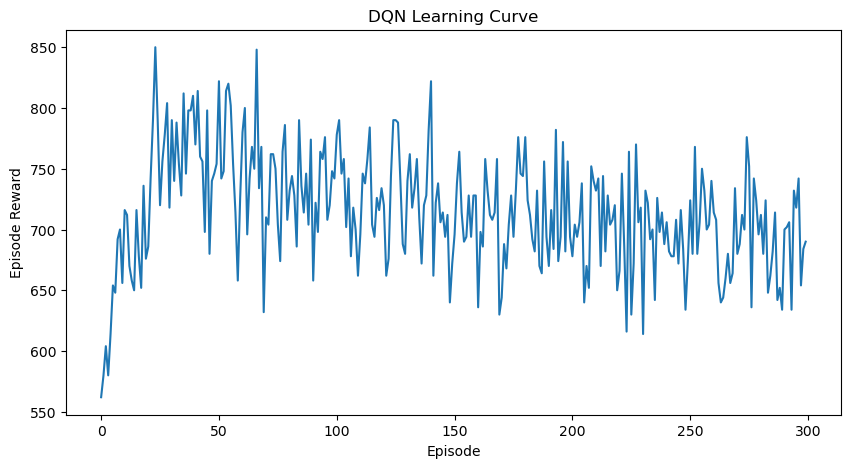

In [ ]:
main() # use training data for testing, clf=2

Balanced training dataset with 10000 samples
Loaded testing dataset with 275 samples
Using device: cpu


  0%|          | 1/300 [00:00<00:32,  9.19it/s]

Episode 0, Avg Reward: 274.00, Epsilon: 0.91


  4%|▍         | 12/300 [00:01<00:33,  8.69it/s]

Episode 10, Avg Reward: 319.00, Epsilon: 0.37


  7%|▋         | 22/300 [00:02<00:32,  8.62it/s]

Episode 20, Avg Reward: 327.20, Epsilon: 0.17


 11%|█         | 32/300 [00:03<00:33,  8.08it/s]

Episode 30, Avg Reward: 343.80, Epsilon: 0.09


 14%|█▍        | 42/300 [00:05<00:31,  8.15it/s]

Episode 40, Avg Reward: 333.80, Epsilon: 0.07


 17%|█▋        | 52/300 [00:06<00:30,  8.18it/s]

Episode 50, Avg Reward: 316.00, Epsilon: 0.06


 21%|██        | 62/300 [00:07<00:28,  8.23it/s]

Episode 60, Avg Reward: 349.40, Epsilon: 0.05


 24%|██▍       | 72/300 [00:08<00:27,  8.15it/s]

Episode 70, Avg Reward: 346.20, Epsilon: 0.05


 27%|██▋       | 82/300 [00:09<00:26,  8.14it/s]

Episode 80, Avg Reward: 335.80, Epsilon: 0.05


 31%|███       | 92/300 [00:11<00:25,  8.19it/s]

Episode 90, Avg Reward: 355.20, Epsilon: 0.05


 34%|███▍      | 102/300 [00:12<00:24,  8.20it/s]

Episode 100, Avg Reward: 357.20, Epsilon: 0.05


 37%|███▋      | 112/300 [00:13<00:23,  8.07it/s]

Episode 110, Avg Reward: 327.40, Epsilon: 0.05


 41%|████      | 122/300 [00:14<00:22,  7.78it/s]

Episode 120, Avg Reward: 339.00, Epsilon: 0.05


 44%|████▍     | 132/300 [00:16<00:21,  7.83it/s]

Episode 130, Avg Reward: 356.60, Epsilon: 0.05


 47%|████▋     | 142/300 [00:17<00:19,  8.06it/s]

Episode 140, Avg Reward: 337.60, Epsilon: 0.05


 51%|█████     | 152/300 [00:18<00:18,  8.13it/s]

Episode 150, Avg Reward: 343.20, Epsilon: 0.05


 54%|█████▍    | 162/300 [00:19<00:16,  8.27it/s]

Episode 160, Avg Reward: 333.20, Epsilon: 0.05


 57%|█████▋    | 172/300 [00:21<00:15,  8.26it/s]

Episode 170, Avg Reward: 342.20, Epsilon: 0.05


 61%|██████    | 182/300 [00:22<00:14,  8.32it/s]

Episode 180, Avg Reward: 344.00, Epsilon: 0.05


 64%|██████▍   | 192/300 [00:23<00:13,  7.97it/s]

Episode 190, Avg Reward: 338.20, Epsilon: 0.05


 67%|██████▋   | 202/300 [00:24<00:12,  8.01it/s]

Episode 200, Avg Reward: 332.40, Epsilon: 0.05


 71%|███████   | 212/300 [00:26<00:10,  8.06it/s]

Episode 210, Avg Reward: 355.00, Epsilon: 0.05


 74%|███████▍  | 222/300 [00:27<00:09,  8.26it/s]

Episode 220, Avg Reward: 339.40, Epsilon: 0.05


 77%|███████▋  | 232/300 [00:28<00:08,  8.14it/s]

Episode 230, Avg Reward: 350.60, Epsilon: 0.05


 81%|████████  | 242/300 [00:29<00:07,  8.28it/s]

Episode 240, Avg Reward: 346.40, Epsilon: 0.05


 84%|████████▍ | 252/300 [00:30<00:05,  8.31it/s]

Episode 250, Avg Reward: 340.60, Epsilon: 0.05


 87%|████████▋ | 262/300 [00:32<00:04,  8.17it/s]

Episode 260, Avg Reward: 345.20, Epsilon: 0.05


 91%|█████████ | 272/300 [00:33<00:03,  7.39it/s]

Episode 270, Avg Reward: 340.00, Epsilon: 0.05


 94%|█████████▍| 282/300 [00:34<00:02,  7.63it/s]

Episode 280, Avg Reward: 349.80, Epsilon: 0.05


 97%|█████████▋| 292/300 [00:35<00:01,  7.99it/s]

Episode 290, Avg Reward: 343.60, Epsilon: 0.05


100%|██████████| 300/300 [00:36<00:00,  8.11it/s]


Evaluation: Avg Reward: 165.00 +/- 0.00


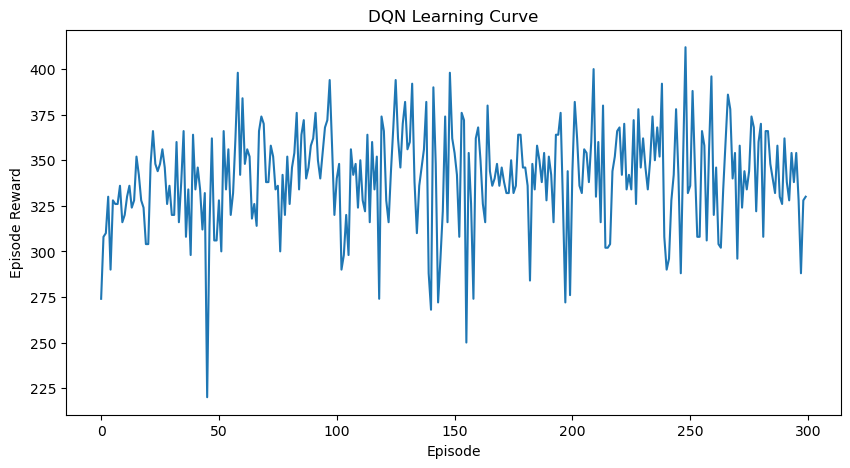

In [ ]:
main() # use training data for testing, clf=3

Balanced training dataset with 10000 samples
Loaded testing dataset with 69 samples
Using device: cpu


  0%|          | 1/300 [00:00<00:32,  9.28it/s]

Episode 0, Avg Reward: 252.00, Epsilon: 0.91


  4%|▍         | 12/300 [00:01<00:29,  9.78it/s]

Episode 10, Avg Reward: 286.80, Epsilon: 0.37


  7%|▋         | 22/300 [00:02<00:30,  9.09it/s]

Episode 20, Avg Reward: 333.40, Epsilon: 0.17


 11%|█         | 32/300 [00:03<00:30,  8.88it/s]

Episode 30, Avg Reward: 343.40, Epsilon: 0.09


 14%|█▍        | 42/300 [00:04<00:29,  8.78it/s]

Episode 40, Avg Reward: 362.60, Epsilon: 0.07


 17%|█▋        | 52/300 [00:05<00:30,  8.15it/s]

Episode 50, Avg Reward: 344.20, Epsilon: 0.06


 21%|██        | 62/300 [00:07<00:29,  8.00it/s]

Episode 60, Avg Reward: 355.00, Epsilon: 0.05


 24%|██▍       | 72/300 [00:08<00:27,  8.22it/s]

Episode 70, Avg Reward: 354.20, Epsilon: 0.05


 27%|██▋       | 82/300 [00:09<00:25,  8.62it/s]

Episode 80, Avg Reward: 343.00, Epsilon: 0.05


 31%|███       | 92/300 [00:10<00:23,  8.76it/s]

Episode 90, Avg Reward: 350.40, Epsilon: 0.05


 34%|███▍      | 102/300 [00:11<00:22,  8.67it/s]

Episode 100, Avg Reward: 347.40, Epsilon: 0.05


 37%|███▋      | 112/300 [00:12<00:22,  8.42it/s]

Episode 110, Avg Reward: 331.80, Epsilon: 0.05


 41%|████      | 122/300 [00:14<00:20,  8.68it/s]

Episode 120, Avg Reward: 352.60, Epsilon: 0.05


 44%|████▍     | 132/300 [00:15<00:19,  8.47it/s]

Episode 130, Avg Reward: 349.20, Epsilon: 0.05


 47%|████▋     | 142/300 [00:16<00:17,  8.82it/s]

Episode 140, Avg Reward: 360.00, Epsilon: 0.05


 51%|█████     | 152/300 [00:17<00:17,  8.49it/s]

Episode 150, Avg Reward: 339.40, Epsilon: 0.05


 54%|█████▍    | 162/300 [00:18<00:15,  8.75it/s]

Episode 160, Avg Reward: 344.00, Epsilon: 0.05


 57%|█████▋    | 172/300 [00:19<00:15,  8.49it/s]

Episode 170, Avg Reward: 347.60, Epsilon: 0.05


 61%|██████    | 182/300 [00:21<00:13,  8.59it/s]

Episode 180, Avg Reward: 356.40, Epsilon: 0.05


 64%|██████▍   | 192/300 [00:22<00:12,  8.42it/s]

Episode 190, Avg Reward: 344.20, Epsilon: 0.05


 67%|██████▋   | 202/300 [00:23<00:11,  8.53it/s]

Episode 200, Avg Reward: 346.60, Epsilon: 0.05


 71%|███████   | 212/300 [00:24<00:10,  8.27it/s]

Episode 210, Avg Reward: 361.00, Epsilon: 0.05


 74%|███████▍  | 222/300 [00:25<00:09,  8.14it/s]

Episode 220, Avg Reward: 336.80, Epsilon: 0.05


 77%|███████▋  | 232/300 [00:27<00:08,  8.34it/s]

Episode 230, Avg Reward: 350.40, Epsilon: 0.05


 81%|████████  | 242/300 [00:28<00:06,  8.56it/s]

Episode 240, Avg Reward: 350.80, Epsilon: 0.05


 84%|████████▍ | 252/300 [00:29<00:05,  8.40it/s]

Episode 250, Avg Reward: 339.60, Epsilon: 0.05


 87%|████████▋ | 262/300 [00:30<00:05,  7.04it/s]

Episode 260, Avg Reward: 354.60, Epsilon: 0.05


 91%|█████████ | 272/300 [00:32<00:03,  7.82it/s]

Episode 270, Avg Reward: 353.60, Epsilon: 0.05


 94%|█████████▍| 282/300 [00:33<00:02,  8.58it/s]

Episode 280, Avg Reward: 350.40, Epsilon: 0.05


 97%|█████████▋| 292/300 [00:34<00:00,  8.62it/s]

Episode 290, Avg Reward: 361.00, Epsilon: 0.05


100%|██████████| 300/300 [00:35<00:00,  8.46it/s]


Evaluation: Avg Reward: 17.00 +/- 0.00


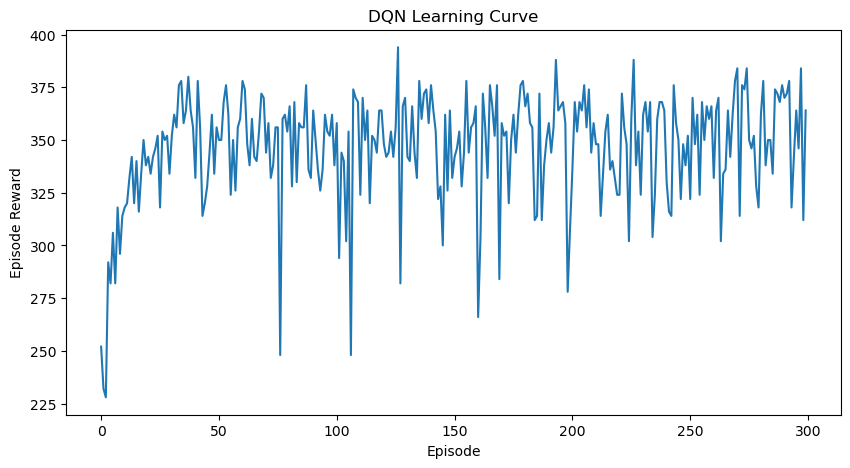

In [48]:
main() # testing,clf=1

Balanced training dataset with 10000 samples
Loaded testing dataset with 69 samples
Using device: cpu


  0%|          | 1/300 [00:00<00:33,  8.88it/s]

Episode 0, Avg Reward: 586.00, Epsilon: 0.91


  4%|▍         | 12/300 [00:01<00:32,  8.92it/s]

Episode 10, Avg Reward: 666.80, Epsilon: 0.37


  7%|▋         | 22/300 [00:02<00:32,  8.50it/s]

Episode 20, Avg Reward: 708.60, Epsilon: 0.17


 11%|█         | 32/300 [00:03<00:31,  8.55it/s]

Episode 30, Avg Reward: 748.60, Epsilon: 0.09


 14%|█▍        | 42/300 [00:04<00:30,  8.59it/s]

Episode 40, Avg Reward: 781.20, Epsilon: 0.07


 17%|█▋        | 52/300 [00:05<00:28,  8.58it/s]

Episode 50, Avg Reward: 736.80, Epsilon: 0.06


 21%|██        | 62/300 [00:07<00:29,  8.14it/s]

Episode 60, Avg Reward: 776.00, Epsilon: 0.05


 24%|██▍       | 72/300 [00:08<00:26,  8.47it/s]

Episode 70, Avg Reward: 737.40, Epsilon: 0.05


 27%|██▋       | 82/300 [00:09<00:25,  8.43it/s]

Episode 80, Avg Reward: 746.00, Epsilon: 0.05


 31%|███       | 92/300 [00:10<00:25,  8.18it/s]

Episode 90, Avg Reward: 740.20, Epsilon: 0.05


 34%|███▍      | 102/300 [00:11<00:23,  8.55it/s]

Episode 100, Avg Reward: 717.60, Epsilon: 0.05


 37%|███▋      | 112/300 [00:13<00:22,  8.45it/s]

Episode 110, Avg Reward: 724.00, Epsilon: 0.05


 41%|████      | 122/300 [00:14<00:20,  8.49it/s]

Episode 120, Avg Reward: 718.20, Epsilon: 0.05


 44%|████▍     | 132/300 [00:15<00:19,  8.65it/s]

Episode 130, Avg Reward: 716.60, Epsilon: 0.05


 47%|████▋     | 142/300 [00:16<00:18,  8.63it/s]

Episode 140, Avg Reward: 710.40, Epsilon: 0.05


 51%|█████     | 152/300 [00:17<00:17,  8.28it/s]

Episode 150, Avg Reward: 727.20, Epsilon: 0.05


 54%|█████▍    | 162/300 [00:19<00:16,  8.22it/s]

Episode 160, Avg Reward: 707.00, Epsilon: 0.05


 57%|█████▋    | 172/300 [00:20<00:15,  8.02it/s]

Episode 170, Avg Reward: 700.20, Epsilon: 0.05


 61%|██████    | 182/300 [00:21<00:14,  8.42it/s]

Episode 180, Avg Reward: 691.80, Epsilon: 0.05


 64%|██████▍   | 192/300 [00:22<00:13,  8.05it/s]

Episode 190, Avg Reward: 692.40, Epsilon: 0.05


 67%|██████▋   | 202/300 [00:23<00:11,  8.49it/s]

Episode 200, Avg Reward: 687.20, Epsilon: 0.05


 71%|███████   | 212/300 [00:25<00:10,  8.60it/s]

Episode 210, Avg Reward: 690.00, Epsilon: 0.05


 74%|███████▍  | 222/300 [00:26<00:09,  8.46it/s]

Episode 220, Avg Reward: 701.00, Epsilon: 0.05


 77%|███████▋  | 232/300 [00:27<00:08,  7.92it/s]

Episode 230, Avg Reward: 706.40, Epsilon: 0.05


 81%|████████  | 242/300 [00:28<00:06,  8.43it/s]

Episode 240, Avg Reward: 684.20, Epsilon: 0.05


 84%|████████▍ | 252/300 [00:29<00:05,  8.29it/s]

Episode 250, Avg Reward: 683.00, Epsilon: 0.05


 87%|████████▋ | 262/300 [00:31<00:04,  8.21it/s]

Episode 260, Avg Reward: 674.80, Epsilon: 0.05


 91%|█████████ | 272/300 [00:32<00:03,  8.50it/s]

Episode 270, Avg Reward: 670.20, Epsilon: 0.05


 94%|█████████▍| 282/300 [00:33<00:02,  8.53it/s]

Episode 280, Avg Reward: 695.00, Epsilon: 0.05


 97%|█████████▋| 292/300 [00:34<00:00,  8.59it/s]

Episode 290, Avg Reward: 678.00, Epsilon: 0.05


100%|██████████| 300/300 [00:35<00:00,  8.44it/s]


Evaluation: Avg Reward: 41.00 +/- 0.00


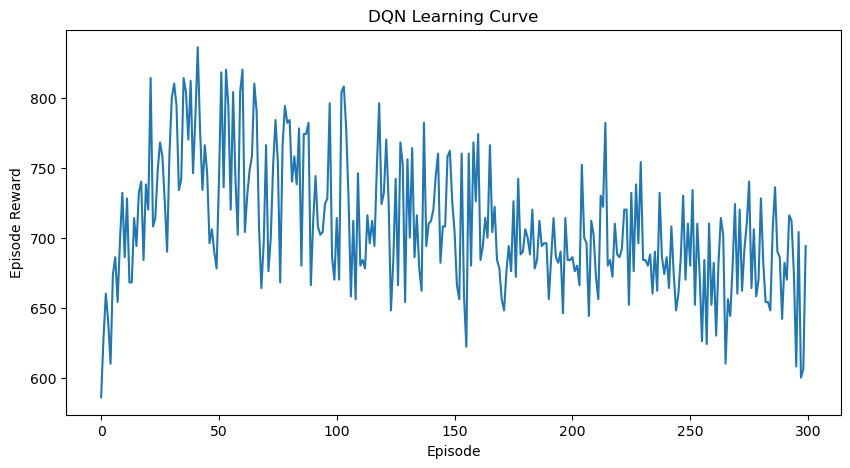

In [46]:
main() # testing,clf=2

Balanced training dataset with 10000 samples
Loaded testing dataset with 69 samples
Using device: cpu


  0%|          | 1/300 [00:00<00:33,  8.83it/s]

Episode 0, Avg Reward: 338.00, Epsilon: 0.91


  4%|▍         | 12/300 [00:01<00:31,  9.24it/s]

Episode 10, Avg Reward: 324.20, Epsilon: 0.37


  7%|▋         | 22/300 [00:02<00:32,  8.57it/s]

Episode 20, Avg Reward: 342.00, Epsilon: 0.17


 11%|█         | 32/300 [00:03<00:32,  8.28it/s]

Episode 30, Avg Reward: 343.80, Epsilon: 0.09


 14%|█▍        | 42/300 [00:04<00:31,  8.32it/s]

Episode 40, Avg Reward: 346.80, Epsilon: 0.07


 17%|█▋        | 52/300 [00:06<00:30,  8.21it/s]

Episode 50, Avg Reward: 347.60, Epsilon: 0.06


 21%|██        | 62/300 [00:07<00:29,  8.14it/s]

Episode 60, Avg Reward: 339.40, Epsilon: 0.05


 24%|██▍       | 72/300 [00:08<00:28,  8.12it/s]

Episode 70, Avg Reward: 341.80, Epsilon: 0.05


 27%|██▋       | 82/300 [00:09<00:26,  8.13it/s]

Episode 80, Avg Reward: 336.60, Epsilon: 0.05


 31%|███       | 92/300 [00:10<00:25,  8.31it/s]

Episode 90, Avg Reward: 332.20, Epsilon: 0.05


 34%|███▍      | 102/300 [00:12<00:24,  8.17it/s]

Episode 100, Avg Reward: 352.20, Epsilon: 0.05


 37%|███▋      | 112/300 [00:13<00:22,  8.29it/s]

Episode 110, Avg Reward: 345.20, Epsilon: 0.05


 41%|████      | 122/300 [00:14<00:21,  8.16it/s]

Episode 120, Avg Reward: 330.60, Epsilon: 0.05


 44%|████▍     | 132/300 [00:15<00:20,  8.10it/s]

Episode 130, Avg Reward: 346.20, Epsilon: 0.05


 47%|████▋     | 142/300 [00:17<00:19,  8.21it/s]

Episode 140, Avg Reward: 335.80, Epsilon: 0.05


 51%|█████     | 152/300 [00:18<00:18,  8.15it/s]

Episode 150, Avg Reward: 341.40, Epsilon: 0.05


 54%|█████▍    | 162/300 [00:19<00:16,  8.16it/s]

Episode 160, Avg Reward: 334.80, Epsilon: 0.05


 57%|█████▋    | 172/300 [00:20<00:15,  8.18it/s]

Episode 170, Avg Reward: 331.20, Epsilon: 0.05


 61%|██████    | 182/300 [00:22<00:14,  8.24it/s]

Episode 180, Avg Reward: 336.60, Epsilon: 0.05


 64%|██████▍   | 192/300 [00:23<00:13,  8.27it/s]

Episode 190, Avg Reward: 324.60, Epsilon: 0.05


 67%|██████▋   | 202/300 [00:24<00:11,  8.29it/s]

Episode 200, Avg Reward: 330.20, Epsilon: 0.05


 71%|███████   | 212/300 [00:25<00:10,  8.12it/s]

Episode 210, Avg Reward: 320.60, Epsilon: 0.05


 74%|███████▍  | 222/300 [00:26<00:09,  8.35it/s]

Episode 220, Avg Reward: 332.80, Epsilon: 0.05


 77%|███████▋  | 232/300 [00:28<00:08,  8.21it/s]

Episode 230, Avg Reward: 326.00, Epsilon: 0.05


 81%|████████  | 242/300 [00:29<00:06,  8.30it/s]

Episode 240, Avg Reward: 332.40, Epsilon: 0.05


 84%|████████▍ | 252/300 [00:30<00:05,  8.31it/s]

Episode 250, Avg Reward: 318.60, Epsilon: 0.05


 87%|████████▋ | 262/300 [00:31<00:04,  8.35it/s]

Episode 260, Avg Reward: 335.20, Epsilon: 0.05


 91%|█████████ | 272/300 [00:33<00:03,  7.35it/s]

Episode 270, Avg Reward: 320.00, Epsilon: 0.05


 94%|█████████▍| 282/300 [00:34<00:02,  8.08it/s]

Episode 280, Avg Reward: 326.20, Epsilon: 0.05


 97%|█████████▋| 292/300 [00:35<00:00,  8.37it/s]

Episode 290, Avg Reward: 326.80, Epsilon: 0.05


100%|██████████| 300/300 [00:36<00:00,  8.23it/s]


Evaluation: Avg Reward: 19.00 +/- 0.00


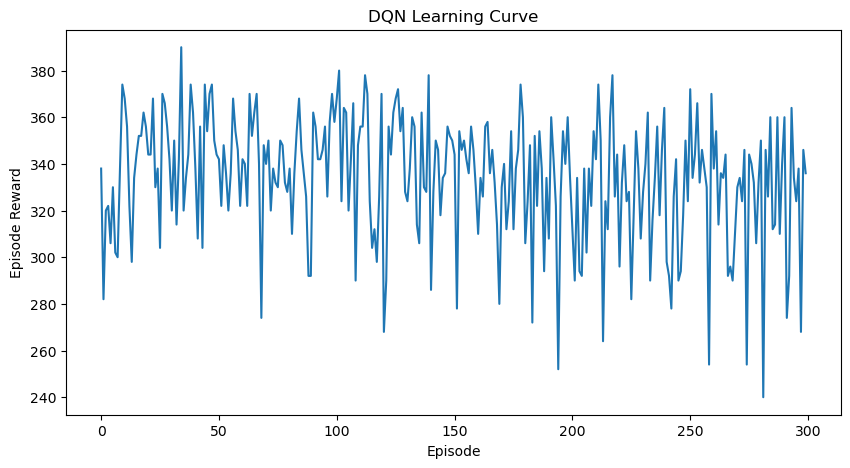

In [44]:
main() # testing,clf=3